<style>
@import url('https://fonts.googleapis.com/css2?family=Vazirmatn&display=swap')
</style>
<link rel="stylesheet" type="text/css" href="../../custom_jupyter_style.css">

.

<div style="direction:rtl; width:100%; border:0px solid gray; border-radius:8px; padding:16px; box-sizing:border-box"> 
<H1> پروژه اول درس علوم اعصاب محاسباتی </H1>
<H2> امیرعلی امینی </H2>
<H3> ۶۱۰۳۹۹۱۰۲ </H3>
<hr/>
<H3>هدف پروژه: </H3>
در این پروژه به بررسی مدل های نورونی <b> LIF, ELIF, AELIF </b> میپردازیم. در این پروژه جریان های ورودی متفاوت شامل جریان های
<ol style="border-right:1px solid gray; margin:8px">
    <li>جریان ثابت</li>
    <li>جریان ثابت با نویز</li>
    <li>جریان پله ای</li>
    <li>جریان پله ای با نویز</li>
    <li>جریان سینوسی</li>
    <li>جریان سینوسی با نویز</li>
    <li>جریان با تغییرات یونیفرم</li>
    <li>جریان با تغییرات یونیفرم با نویز</li>
</ol>
میپردازیم. همچنین در این پروژه بر روی اهمیت و تاثیر پارامتر های مدل ها متمرکز میشویم و سعی بر این است که به صورت دقیق آنها را بررسی کنیم.

همچنین در نهایت به مقایسه مدل تغییر یافته توسط من و مدل AELIF میپردازیم.
</div>

In [1]:
import pymonntorch as pmt
import torch 
from matplotlib import pyplot as plt


# مقدمات پیاده سازی :
برای پیاده سازی مدل ها ابتدا یک BaseModel تعریف کردم که با تغییر دادن برخی پارامتر ها از مقدار اولیه که صفر یا False هستند میتوانیم مدل های نورونی ELIF و AELIF را نیز داشته باشیم. در واقع مدل نورونی AELIF را پیاده سازی کردم که مقادیر اولیه پارامتر هایی که مربوط به مدل LIF نیست را صفر قرار دادم که در محسابت لحاظر نشوند

این کار به این دلیل ممکن است که هر دو مدل ELIF و AELIF مدل ها پیشرفت داده شده LIF هستند و بی تاثیر کردن برخی قسمت های فرمول های آنها میتوان به LIF رسید.

این شرایط برای دو مدل ELIF و AELIF نیز قرار است.

سپس سه تابع با نام مدل ها ساختم که یک instance از کلاس ها برمیگرداند. ورودی های هر تابع دقیقا ورودی های یکی از سه مدل هستند. از مزایای این کار 
1. پیشنهاد شدن پارامتر ها توسط auto suggestion vscode  
2. پارامتر اضافه ندادن به مدل

میباشند.

به طور مثال پارامتر های 
- self.u_rh = self.parameter("u_rh", -60)
- self.delta_t = self.parameter("delta_t", 0)

مربوط به ELIF و متغییر های 
- self.a = self.parameter("a",0)
- self.b = self.parameter("b",0)
- self.tau_w = self.parameter("tau_w", 0)

مربوط به AELIF هستند.

همچنین برای جلوگیری از صفر شدن مخرج کسر در قسمت نمایی مدل ELIF با قرار دادن OR در مخرج کسر این مشکل رو حل کردم:

```python
exp_part = self.delta_t * torch.exp((ng.u - self.u_rh)/(self.delta_t or 1))
```

مدل ها نیر به صورت 

```python
def LIF (threshold=-55,
         u_rest=-65,
         u_reset=-73.42, 
         R=1.7,
         tau_m=10,
         refractory_period = 0):
    return BaseModel(threshold=threshold, 
                     u_reset=u_reset, 
                     u_rest=u_rest, 
                     R=R, 
                     tau_m=tau_m,
                     refractory_period=refractory_period)
```
ساخته شدند

In [2]:
import model as mdl
import current as cnt
from getDevice import get_device
from dt import TimeResolution
from plot import plot

# تابع کلی:
در این تابع به ازای هر بار اجرا شدن یک شبکه(network) و یک گروه نورونی (neuron group) ساخته میشود. این موضوع به این دلیل است که نیاز به شبکه و گروه های نورونی متفاوت برای هر قسمت از تمرین داریم و جهت کوتاه تر شدن شد ها قرار گرفته است.

در این قسمت دو ثبت کننده (recorder) داریم که یکی از آنها مقادیر 
- U (voltage)
- I (current)
- W (adaptive variable)

را ثبت میکند و دیگری زمان ضربه(spike) را به خاطر میسپارد.

In [3]:

def simulate(title="LIF",
              model=mdl.LIF(),
              current=cnt.SteadyCurrent(value=6),
                DEVICE=get_device(force_cpu=True )[0],
                 dt=0.5 ,
                 iteration=1000,
                 ng_size=2,
                 print_plots = True):

      net = pmt.Network(device=DEVICE, dtype=torch.float32, behavior={1: TimeResolution(dt=dt)})

      ng = pmt.NeuronGroup(size= ng_size,net= net, behavior= {
                                        2: current,
                                        4: model,
                                        
                                        9: pmt.Recorder(variables=["u", "I","w"], tag="ng1_rec, ng1_recorder"),
                                        10: pmt.EventRecorder("spike", tag="ng1_evrec"),
                                      }
                                      )



      net.initialize()

      net.simulate_iterations(iteration)

      plot_title = f"[[{title}]]\n"
      mean_u = torch.sum(net["u", 0], axis=0) / (iteration)
      mean_I = torch.sum(net["I", 0], axis=0) / (iteration)

      plot_title += "\n".join([ f"current: {ng[2][0]}", 
                               f"model: {ng[4][0]}", 
                               f"time resolution: {dt}", 
                               f"ng size: {ng_size}", 
                               f"iteration num: {iteration}",
                               f"mean u: {mean_u}",
                               f"mean I: {mean_I}",
                                 ])


      print_plots and plot(net,plot_title)
      return net

mps is available but it is forced to use CPU


# توابع F/I
در این قسمت توابعی که برای بدست اوردن مقدار F بر حسب جریان ورودی است قرار گرفته اند به این صورت که برای جریان های ۰ تا یک مقدار مشخص، مقدار F به ازای هر مقدار جریان بر هست گام مشخص شده بدست می‌آید و نمودار آن در نهایت کشیده میشود.

In [4]:
def simulate_IF_LIF(current=cnt.SteadyCurrent,
                    rng=20, 
                    step=1,
                    dt=1,
                    iteration=1000,
                    title="LIF",
                    noise_range=0):
    F = []
    I = []
    for i in range(1,rng,step):
        net = simulate(current=current(value=i, noise_range = noise_range),print_plots=False)
        I.append(i)
        F.append(len(net["spike", 0][:, 0]) / dt*iteration)
    plt.plot(I,F)
    plt.title(f"{title}, noise range: {noise_range}")
    plt.xlabel("I")
    plt.ylabel("F")
    plt.show()


def simulate_IF_ELIF(current=cnt.SteadyCurrent,
                     rng=20,
                     step=1,
                     dt=0.5,
                     iteration=1000,
                     title="ELIF",
                     noise_range=0):
    F = []
    I = []
    for i in range(1,rng,step):
        net = simulate(model=mdl.ELIF(u_rh=-50),current=current(value=i, noise_range = noise_range),print_plots=False)
        I.append(i)
        F.append(len(net["spike", 0][:, 0]) / dt*iteration)
    plt.plot(I,F)
    plt.title(f"{title}, noise range: {noise_range}")
    plt.xlabel("I")
    plt.ylabel("F")
    plt.show()

def simulate_IF_AELIF(current=cnt.SteadyCurrent,
                      rng=20,
                      step=1,
                      dt=0.5,
                      iteration=1000,
                      title="AELIF",
                      noise_range=0):
    F = []
    I = []
    for i in range(1,rng,step):
        net = simulate(model=mdl.AELIF(u_rh=-50,tau_w=1,b=0.01),current=current(value=i, noise_range = noise_range),print_plots=False)
        I.append(i)
        F.append(len(net["spike", 0][:, 0]) / dt * iteration)
    plt.plot(I,F)
    plt.title(f"{title}, noise range: {noise_range}")
    plt.xlabel("I")
    plt.ylabel("F")
    plt.show()


In [5]:
def simulate_mean_LIF(current=cnt.SteadyCurrent,
                    rng=20, 
                    step=1,
                    dt=1,
                    iteration=1000,
                    title="LIF",
                    noise_range=0):
    I = []
    U = []
    for i in range(1,rng,step):
        net = simulate(current=current(value=i, noise_range = noise_range),print_plots=False)
        mean_u = torch.sum(net["u", 0], axis=0) / (iteration)
        mean_I = torch.sum(net["I", 0], axis=0) / (iteration)
        I.append(mean_I)
        U.append(mean_u)
    plt.plot(I,U)
    plt.title(f"{title}, noise range: {noise_range}")
    plt.xlabel("Mean I")
    plt.ylabel("Mean U")
    plt.show()


def simulate_mean_ELIF(current=cnt.SteadyCurrent,
                     rng=20,
                     step=1,
                     dt=0.5,
                     iteration=1000,
                     title="ELIF",
                     noise_range=0):
    I = []
    U = []
    for i in range(1,rng,step):
        net = simulate(model=mdl.ELIF(u_rh=-50),current=current(value=i, noise_range = noise_range),print_plots=False)
        mean_u = torch.sum(net["u", 0], axis=0) / (iteration)
        mean_I = torch.sum(net["I", 0], axis=0) / (iteration)
        I.append(mean_I)
        U.append(mean_u)
    plt.plot(I,U)
    plt.title(f"{title}, noise range: {noise_range}")
    plt.xlabel("Mean I")
    plt.ylabel("Mean U")
    plt.show()

def simulate_mean_AELIF(current=cnt.SteadyCurrent,
                      rng=20,
                      step=1,
                      dt=0.5,
                      iteration=1000,
                      title="AELIF",
                      noise_range=0):
    I = []
    U = []
    for i in range(1,rng,step):
        net = simulate(model=mdl.AELIF(u_rh=-50,tau_w=1,b=0.01),current=current(value=i, noise_range = noise_range),print_plots=False)
        mean_u = torch.sum(net["u", 0], axis=0) / (iteration)
        mean_I = torch.sum(net["I", 0], axis=0) / (iteration)
        I.append(mean_I)
        U.append(mean_u)
    plt.plot(I,U)
    plt.title(f"{title}, noise range: {noise_range}")
    plt.xlabel("Mean I")
    plt.ylabel("Mean U")
    plt.show()


In [6]:
raise KeyError("prevent running fllowing cells")

KeyError: 'prevent running fllowing cells'

# قسمت آ)

## SteadyCurrent

### A - 1 - LIF

####  A - 1 - LIF

در این قسمت مدل نورونی LIF با جریان ثابت قرار دارد و در قسمت بعدی این مدل با جریان ثابت نویز دار قرار گرفته است. پارامتر ها طوری تنظیم شده اند که در ۱۰۰۰ مرحله (iteration) و با دقت زمانی (time resolution) ۰.۱، تغییرات به صورت قابل فهم و تمایز باشند.

Network['Network_1', 'Network'](Neurons: tensor(2)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution(dt=0.5,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](2){2:SteadyCurrent(value=2,)4:BaseModel(threshold=-55,u_reset=-70,u_rest=-65,R=1.7,tau_m=10,refractory_period=0,)9:Recorder(variables=['u', 'I', 'w'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}
1000xBatch: 1/1 (100%) 155.024ms


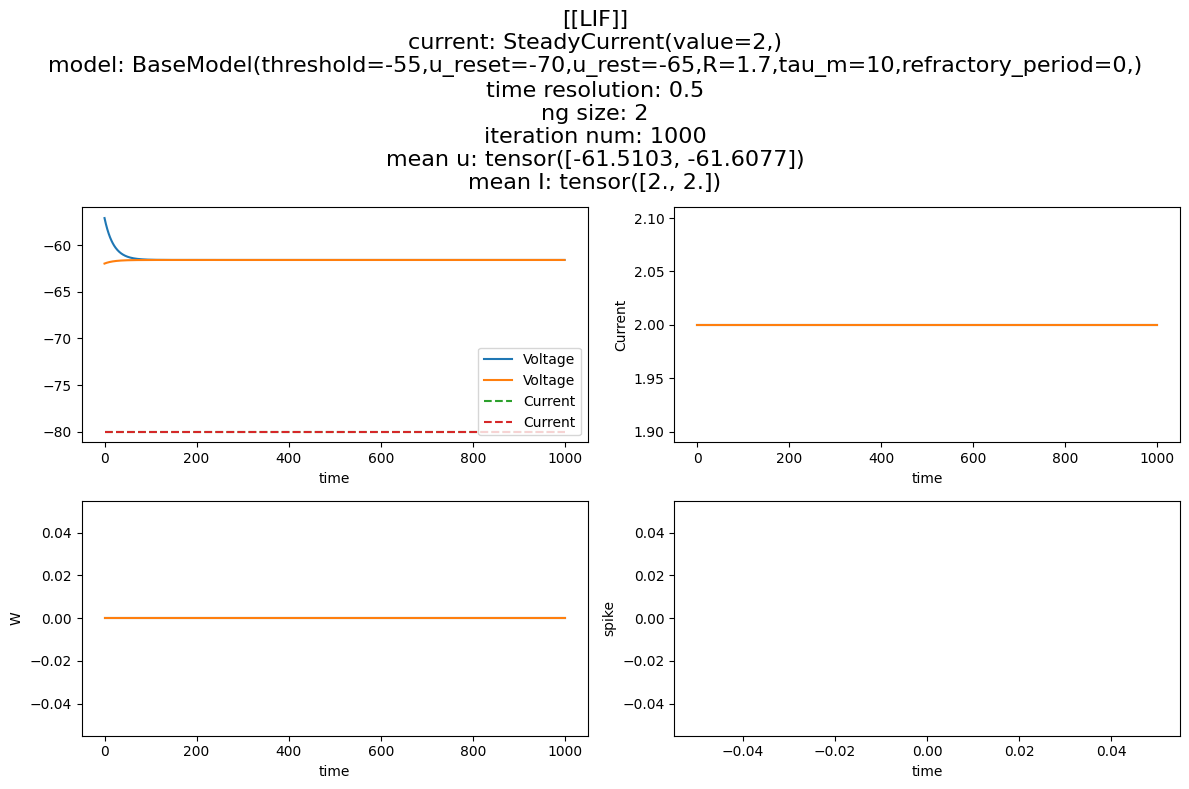

Network['Network_1', 'Network'](Neurons: tensor(2)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution(dt=0.5,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](2){2:SteadyCurrent(value=2,)4:BaseModel(threshold=-55,u_reset=-70,u_rest=-65,R=1.7,tau_m=10,refractory_period=0,)9:Recorder(variables=['u', 'I', 'w'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}

In [7]:
simulate(current=cnt.SteadyCurrent(value=2))


In [ ]:
simulate(current=cnt.SteadyCurrent(value=4))


: 

In [ ]:
simulate()


: 

In [ ]:
simulate(current=cnt.SteadyCurrent(value=8))


: 

####  A - 1 - LIF - Noised

In [ ]:
simulate(current=cnt.SteadyCurrent(value=2, noise_range=1))

: 

In [ ]:
simulate(current=cnt.SteadyCurrent(value=4, noise_range=1))


: 

In [ ]:
simulate(current=cnt.SteadyCurrent(value=6, noise_range=1))


: 

In [ ]:
simulate(current=cnt.SteadyCurrent(value=8, noise_range=1))


: 

### -

### A - 1 - ELIF

#### A - 1 - ELIF

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50), current=cnt.SteadyCurrent(value=2), title="A-1-ELIF")

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50), current=cnt.SteadyCurrent(value=7), title="A-ELIF")


: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50), current=cnt.SteadyCurrent(value=9), title="A-ELIF")


: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50), current=cnt.SteadyCurrent(value=12), title="A-ELIF")


: 

#### A - 1 - ELIF - Noised

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50), current=cnt.SteadyCurrent(value=2, noise_range=1), title="A-ELIF")

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50), current=cnt.SteadyCurrent(value=7, noise_range=1), title="A-ELIF")


: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50), current=cnt.SteadyCurrent(value=9, noise_range=1), title="A-ELIF")


: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50), current=cnt.SteadyCurrent(value=12, noise_range=1), title="A-ELIF")

: 

### -

### A - 1 - AELIF

#### A - 1 - AELIF

In [ ]:
title = "A-1-AELIF"

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=10), current=cnt.SteadyCurrent(value=0), title=title)

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=10), current=cnt.SteadyCurrent(value=7), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=10), current=cnt.SteadyCurrent(value=50), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=10), current=cnt.SteadyCurrent(value=108), title=title)


: 

#### A - 1  AELIF - Noised

In [ ]:
title = "A-1-AELIF-Noised"

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=10), current=cnt.SteadyCurrent(value=0, noise_range=1), title=title)

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=10,), current=cnt.SteadyCurrent(value=7, noise_range=1), title=title)


: 

increasing tau_w to reduce noise effect

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=1000,b=0.01,a=10,), current=cnt.SteadyCurrent(value=7, noise_range=1), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=10), current=cnt.SteadyCurrent(value=50, noise_range=1), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=10), current=cnt.SteadyCurrent(value=108, noise_range=1), title=title)


: 

### -

## -

## StepFunctionCurrent

### A - 2 - LIF

#### A - 2 - LIF

In [ ]:
title = "A-2-LIF"

: 

In [ ]:
simulate(current=cnt.StepCurrent(value=2), title=title)


: 

In [ ]:
simulate(current=cnt.StepCurrent(value=6))

: 

#### -

#### A - 2 - LIF - Noised

In [ ]:
title = "A-2-LIF-Noised" 
noise_range = 1

: 

In [ ]:
simulate(current=cnt.StepCurrent(value=2, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(current=cnt.StepCurrent(value=6, noise_range=noise_range))

: 

#### -

### -

### A - 2 - ELIF

#### A - 2 - ELIF

In [ ]:
title = "A-2-ELIF"

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.StepCurrent(value=3))


: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.StepCurrent(value=9))


: 

#### -

#### A - 2 - ELIF - Noised

In [ ]:
title = "A-2-ELIF-noised"
noise_range = 1

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.StepCurrent(value=3, noise_range=noise_range))


: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.StepCurrent(value=9, noise_range=noise_range))


: 

#### -

### -

### A - 2 - AELIF

#### A - 2 - AELIF

In [ ]:
title = "A-2-AELIF"
noise_range=0

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=50,b=0.01), current=cnt.StepCurrent(value=5, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=50,b=0.01), current=cnt.StepCurrent(value=18, noise_range=noise_range), title=title)


: 

#### -

#### A - 2 - AELIF - Noised

In [ ]:
title = "A-2-AELIF-noised"
noise_range = 1

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=50,b=0.01), current=cnt.StepCurrent(value=5, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=50,b=0.01), current=cnt.StepCurrent(value=18, noise_range=noise_range), title=title)


: 

#### -

### -

## -

## SinCurrent

### A - 3 - LIF

#### A - 3 - LIF

In [ ]:
title = "A-3-LIF"
noise_range= 0

: 

In [ ]:
simulate(current=cnt.SinCurrent(value=6,stretch_variable=10, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(current= cnt.SinCurrent(value=13,stretch_variable=10, noise_range=noise_range), title=title)

: 

In [ ]:
simulate(current=cnt.SinCurrent(value=6,stretch_variable=1, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(current= cnt.SinCurrent(value=13,stretch_variable=1, noise_range=noise_range), title=title)


: 

#### -

#### A - 3 - LIF - Noised

In [ ]:
title = "A-3-LIF-Noised" 
noise_range = 1

: 

In [ ]:
simulate(current=cnt.SinCurrent(value=6,stretch_variable=10, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(current= cnt.SinCurrent(value=13,stretch_variable=10, noise_range=noise_range), title=title)

: 

In [ ]:
simulate(current=cnt.SinCurrent(value=6,stretch_variable=1, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(current= cnt.SinCurrent(value=13,stretch_variable=1, noise_range=noise_range), title=title)


: 

#### -

### -

### A - 3 - ELIF

#### A - 3 - ELIF

In [ ]:
title = "A-3-ELIF"
noise_range=0

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.SinCurrent(value=6,stretch_variable=10, noise_range=noise_range))
 

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.SinCurrent(value=14,stretch_variable=10, noise_range=noise_range))
 

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.SinCurrent(value=6,stretch_variable=1, noise_range=noise_range))
 

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.SinCurrent(value=14,stretch_variable=1, noise_range=noise_range))
 

: 

#### -

#### A - 3 - ELIF - Noised

In [ ]:
title = "A-3-ELIF-noised"
noise_range = 1

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.SinCurrent(value=6,stretch_variable=10, noise_range=noise_range))
 

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.SinCurrent(value=14,stretch_variable=10, noise_range=noise_range))
 

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.SinCurrent(value=6,stretch_variable=1, noise_range=noise_range))
 

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50),current=cnt.SinCurrent(value=14,stretch_variable=1, noise_range=noise_range))
 

: 

#### -

### -

### A - 3 - AELIF

#### A - 3 - AELIF

In [ ]:
title = "A-3-AELIF"
noise_range=0

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01), current=cnt.SinCurrent(value=6,stretch_variable=10, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01), current=cnt.SinCurrent(value=20,stretch_variable=10, noise_range=noise_range),title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01), current=cnt.SinCurrent(value=6,stretch_variable=1, noise_range=noise_range),title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01), current=cnt.SinCurrent(value=20,stretch_variable=1, noise_range=noise_range), title=title)


: 

change tau_w

In [ ]:
title = "A-3-AELIF"
noise_range=0

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=10,b=0.01), current=cnt.SinCurrent(value=6,stretch_variable=10, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=1000,b=0.01), current=cnt.SinCurrent(value=20,stretch_variable=10, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=10,b=0.01), current=cnt.SinCurrent(value=6,stretch_variable=1, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=10,b=0.01), current=cnt.SinCurrent(value=20,stretch_variable=1, noise_range=noise_range), title=title)


: 

#### -

#### A - 3 - AELIF - Noised

In [ ]:
title = "A-3-AELIF-noised"
noise_range = 1

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01), current=cnt.SinCurrent(value=6,stretch_variable=10, noise_range=noise_range), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01), current=cnt.SinCurrent(value=20,stretch_variable=10, noise_range=noise_range),title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=10,b=0.01), current=cnt.SinCurrent(value=6,stretch_variable=10, noise_range=noise_range), title=title)

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=1000,b=0.01), current=cnt.SinCurrent(value=20,stretch_variable=10, noise_range=noise_range), title=title)

: 

#### -

### -

## -

# -

# قسمت ب)

## B - 1 - LIF 

In [ ]:
title = "B-1-LIF"

: 

In [ ]:
for i in range (4):
    simulate(current=cnt.UniformCurrent(value=5.5, noise_range=(2**i)-1), title=title)


: 

## - 

## B - 1 - ELIF 

In [ ]:
title = "B-1-ELIF"

: 

In [ ]:
for i in range (4):
    simulate( model = mdl.ELIF(u_rh=-50), current=cnt.UniformCurrent(value=9, noise_range=(2**i)-1), title=title)

: 

## - 

## B - 1 - AELIF 

In [ ]:
title = "B-1-AELIF"

: 

In [ ]:
for i in range (4):
    simulate( model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=0.6), 
             current=cnt.UniformCurrent(value=15, noise_range=(2**i)-1), title=title)

: 

In [ ]:
for i in range (4):
    simulate( model=mdl.AELIF(u_rh=-50,tau_w=10,b=0.01,a=0.6), 
             current=cnt.UniformCurrent(value=15, noise_range=(2**i)-1), title=title)

: 

## - 

# -

# قسمت ج اجباری)

## C - 1 - LIF 

In [ ]:
title = "C-1-LIF"

: 

In [ ]:
simulate_IF_LIF(noise_range=0, title=title)

: 

In [ ]:
simulate_IF_LIF(noise_range=10, title=title)


: 

## - 

## C - 1 - ELIF 

In [ ]:
title = "C-1-ELIF"

: 

In [ ]:
simulate_IF_ELIF(title=title)

: 

In [ ]:
simulate_IF_ELIF(noise_range=10, title=title)

: 

## - 

## C - 1 - AELIF 

In [ ]:
title = "C-1-AELIF"

: 

In [ ]:
simulate_IF_AELIF(rng=40, title = title)

: 

In [ ]:
simulate_IF_AELIF(rng=40, noise_range=10, title=title)


: 

## - 

# -

# قسمت ج اختیاری)

## C - 2 - LIF 

In [ ]:
title = "C-2-LIF"

: 

In [ ]:
simulate_mean_LIF(noise_range=0, title=title)

: 

In [ ]:
simulate_mean_LIF(noise_range=10, title=title)


: 

## - 

## C - 2 - ELIF 

In [ ]:
title = "C-2-ELIF"

: 

In [ ]:
simulate_mean_ELIF(title=title)

: 

In [ ]:
simulate_mean_ELIF(noise_range=10, title=title)

: 

## - 

## C - 2 - AELIF 

In [ ]:
title = "C-2-AELIF"

: 

In [ ]:
simulate_mean_AELIF(rng=40, title = title)

: 

In [ ]:
simulate_mean_AELIF(rng=40, noise_range=10, title=title)


: 

## - 

# -

# قسمت د)

## D - 1 - LIF 

In [ ]:
title = "D-1-LIF"

: 

In [ ]:
simulate(model=mdl.LIF(refractory_period=5), current=cnt.SteadyCurrent(value=6),title=title)


: 

In [ ]:
simulate(model=mdl.LIF(refractory_period=5), current=cnt.StepCurrent(value=6),title=title)


: 

In [ ]:
simulate(model=mdl.LIF(refractory_period=5), current=cnt.SinCurrent(value=10, stretch_variable=10),title=title)


: 

In [ ]:

simulate(model=mdl.LIF(refractory_period=5), current=cnt.UniformCurrent(value=6),title=title)

: 

## - 

## D - 1 - ELIF 

In [ ]:
title = "D-1-ELIF"

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50, refractory_period=10),current=cnt.SteadyCurrent(value=9), title=title)

: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50, refractory_period=10),current=cnt.StepCurrent(value=9), title=title)


: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50, refractory_period=10),current=cnt.SinCurrent(value=20, stretch_variable=10), title=title)


: 

In [ ]:
simulate(model=mdl.ELIF(u_rh=-50, refractory_period=10),current=cnt.UniformCurrent(value=9), title=title)


: 

## - 

## D - 1 - AELIF 

In [ ]:
title = "D-1AELIF"

: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=1,a=0.6, refractory_period=10), current=cnt.SteadyCurrent(value=20,stretch_variable=10, noise_range=0), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=1,a=0.6, refractory_period=10), current=cnt.StepCurrent(value=20,stretch_variable=10, noise_range=0), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=1,a=0.6, refractory_period=10), current=cnt.SinCurrent(value=20,stretch_variable=10, noise_range=0), title=title)


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=1,a=0.6, refractory_period=10), current=cnt.UniformCurrent(value=20,stretch_variable=10, noise_range=0), title=title)


: 

## - 

# -

# قسمت آخر)

## پارامتر های مدل

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-50,
                        tau_w=100,
                        b=0.01,
                        a=0.6), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-50,
                        tau_w=100,
                        b=0.01,
                        a=0.001), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-50,
                        tau_w=100,
                        b=0.01,
                        a=10), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-50,
                        tau_w=100,
                        b=0.001,
                        a=0.1), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-50,
                        tau_w=100,
                        b=10,
                        a=0.1), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-50,
                        tau_w=1,
                        b=1,
                        a=0.6), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-50,
                        tau_w=100,
                        b=1,
                        a=0.6), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-60,
                        tau_w=0,
                        b=0.0,
                        a=0.0), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.AELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=1, 
                        refractory_period = 0,
                        u_rh=-41,
                        tau_w=0,
                        b=0.0,
                        a=0.0), current=cnt.SteadyCurrent(value=15), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.ELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=0.1, 
                        refractory_period = 0,
                        u_rh=-50), current=cnt.SteadyCurrent(value=10), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.ELIF(
                        threshold=+30, 
                        u_rest=-65, 
                        u_reset=-70, 
                        R=1.7, 
                        tau_m=10, 
                        delta_t=10, 
                        refractory_period = 0,
                        u_rh=-50), current=cnt.SteadyCurrent(value=10), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1.7,
                        tau_m=100,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-70, 
                        R=2,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-170, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-85,
                        u_reset=-90, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-55,
                        u_reset=-90, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-60,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-50,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 100), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

## -

In [ ]:
simulate(model=mdl.LIF(
                        threshold=-55,
                        u_rest=-65,
                        u_reset=-70, 
                        R=1.7,
                        tau_m=10,
                        refractory_period = 0), current=cnt.SteadyCurrent(value=6), title="parameters of base model")

: 

# -

# ---

---

---

---

# AELIF

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=0.6), current=cnt.UniformCurrent(value=15,stretch_variable=10, noise_range=2))


: 

In [ ]:
simulate(model=mdl.AELIF(u_rh=-50,tau_w=100,b=0.01,a=0.6), current=cnt.UniformCurrent(value=15,stretch_variable=10, noise_range=2))


: 

In [ ]:
simulate_IF_AELIF(rng=40)

: 

: 